In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Contents of Notebook

**Part 1: Import and plot new observed data and new generate rating curve**
- Data was collected from April 2019-January 2020
    - Discharge data was collected via boat and ADCP
    - SSC was calculated from water bottle samples, averaged across 3 locations along a transect
- Data are plotted as Water Discharge vs. SSC
- A rating curve is generated using a power law function between Qw and SSC

**Part 2: Generate and plot rating curves from simulated (HydroTrend) data**
- Reference (historic) scenario
    - Load data into notebook
    - Generate rating curves from model outputs from reference scenario dataset
    - Plot various rating curves: HT-generated (reference), observed data (new), and historic curves
- Recent time scenario
    - Generate rating curves from *2 years* of model outputs (that correspond with date when observed data were collected)
    - Plot various rating curves: HT-generated (2 yrs of data), observed data, and historic curves
        - 2 versions: rcp4.5 and rcp8.5

**Part 3: Compute sediment loads using various methods; compare simulated with observed**
- Observed Qs values
    - Compute HISTORIC Qs via historic rating curve
    - Compute RECENT Qs from observed water data via new rating curve (from 2.3)
- Simulated Qs values
    - Compute HISTORIC Qs using HT-generated rating curves 
    - Compute RECENT Qs from HT data over observation time period (2019-2020)
        - Use new rating curve (from 2.4c) ***for Rcp4.5***
        - Use new rating curve (from 2.4e) ***for Rcp8.5***

## Part 1: Import and plot new observed data and generate new rating curve

### 1.1. Import new observed data

In [2]:
# Data from IWM 
data_obs_new = pd.DataFrame(pd.read_csv('../sed_data/Ganges_q_ssc.txt', delimiter = '\t'))
data_obs_new['Date'] = pd.to_datetime(data_obs_new['Date'], format="%m/%d/%y")
data_obs_new

Date  Discharge (m3/S)  Water Level mPWD  SSC (mg/l)
0  2019-04-13           1357.40              5.24       22.82
1  2019-04-29           1520.14              5.25       37.78
2  2019-05-23           1755.34              6.58       43.10
3  2019-06-11           1409.00              5.70        9.80
4  2019-07-01           3002.96              7.63       31.02
5  2019-07-15          10061.00             10.28      596.38
6  2019-08-03          17674.29             11.86      527.21
7  2019-08-17          21470.65             11.77      491.09
8  2019-09-07          26552.03             12.23      794.17
9  2019-09-24          41809.50             13.74     1229.08
10 2019-10-01          48451.79             13.90      946.71
11 2019-10-13          37491.93             13.67      669.73
12 2019-11-04          11025.82             11.72      145.15
13 2019-11-17           8842.31              9.24      134.73
14 2019-12-26           4487.51              7.10       31.23
15 2020-01-08           2976.82              6.67       13.77
16 2020-01-23           2633.14              6.38       25.62

### 1.2. Plot new observed data

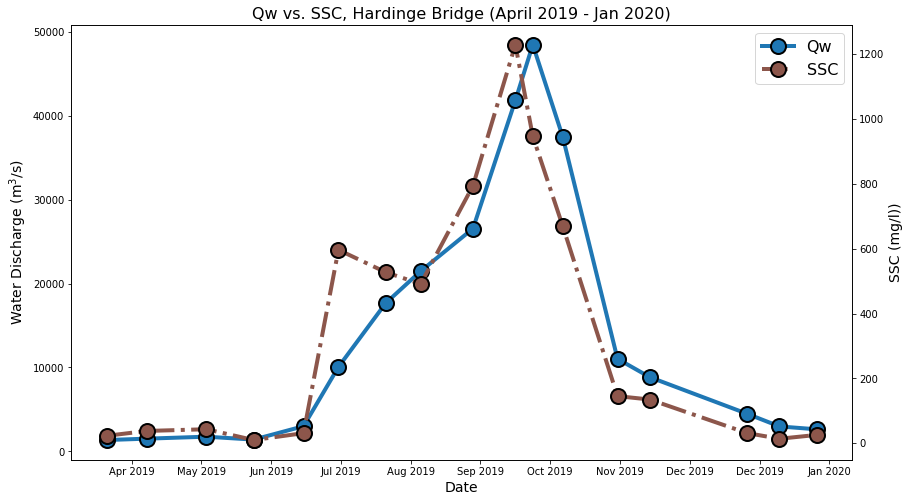

In [3]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from matplotlib import rc
rc('mathtext', default = 'regular')

fig = plt.figure(figsize = (14, 8))
ax = fig.add_subplot()

lns1 = ax.plot(data_obs_new['Date'], data_obs_new['Discharge (m3/S)'],
         '-o', color='tab:blue', markersize=15, 
         linewidth=4,markerfacecolor='tab:blue', 
         markeredgecolor='k', markeredgewidth=2,
        label = 'Qw')

ax2 = ax.twinx()
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
ax2.xaxis.set_major_formatter(DateFormatter("%b %Y"))

lns2 = ax2.plot(data_obs_new['Date'], data_obs_new['SSC (mg/l)'],  
         '-.o', color='tab:brown', markersize=15, linewidth=4,
         markerfacecolor='tab:brown', markeredgecolor='k', markeredgewidth=2,
        label = 'SSC')

lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc = 0, fontsize=16)

#ax.grid()
ax.set_xlabel('Date', size = 14)
ax.set_ylabel('Water Discharge (m$^3/$s)', size = 14)
ax2.set_ylabel('SSC (mg/l))', size = 14)
plt.title('Qw vs. SSC, Hardinge Bridge (April 2019 - Jan 2020)', size = 16)
plt.show()

fig.savefig('../../figures/v2/sed_cal/q_ssc_GR.png')

### 1.3. Generate rating curve from new observed data

In [4]:
# calculate new rating curve with observed data, converting concentration to a flux

from scipy.optimize import curve_fit
from scipy import stats

x = data_obs_new['Discharge (m3/S)']
y = data_obs_new['SSC (mg/l)']*data_obs_new['Discharge (m3/S)']*1e-6/1e-3

new_curve = slope, intercept, rvalue, pvalue, std_err = stats.linregress(np.log(x), np.log(y))
print('new curve: slope: {:.3}    intercept: {:.3}    r-squared: {:.3}'.format(new_curve.slope, np.exp(new_curve.intercept), new_curve.rvalue**2))

new curve: slope: 2.23    intercept: 2.09e-06    r-squared: 0.96


## Part 2: Generate and plot rating curves from simulated (HydroTrend) data
### 2.1. Reference scenario
#### 2.1a) Load data 

In [5]:
# Import hydrotrend data
# Qw
gfdl_qw = np.genfromtxt('../../setup/run_2/Ganga/reference/GFDL-ESM2M/Hydrotrend/HYDROASCII.Q', skip_header = True)
hadgem_qw = np.genfromtxt('../../setup/run_2/Ganga/reference/HadGEM2/Hydrotrend/HYDROASCII.Q', skip_header = True)
ipsl_qw = np.genfromtxt('../../setup/run_2/Ganga/reference/IPSL_CM5A/Hydrotrend/HYDROASCII.Q', skip_header = True)
miroc_qw = np.genfromtxt('../../setup/run_2/Ganga/reference/MIROC-ESM-CHEM/Hydrotrend/HYDROASCII.Q', skip_header = True)
noresm_qw = np.genfromtxt('../../setup/run_2/Ganga/reference/NORESM-M/Hydrotrend/HYDROASCII.Q', skip_header = True)
# Qs
gfdl_qs = np.genfromtxt('../../setup/run_2/Ganga/reference/GFDL-ESM2M/Hydrotrend/HYDROASCII.QS', skip_header = True)
hadgem_qs = np.genfromtxt('../../setup/run_2/Ganga/reference/HadGEM2/Hydrotrend/HYDROASCII.QS', skip_header = True)
ipsl_qs = np.genfromtxt('../../setup/run_2/Ganga/reference/IPSL_CM5A/Hydrotrend/HYDROASCII.QS', skip_header = True)
miroc_qs = np.genfromtxt('../../setup/run_2/Ganga/reference/MIROC-ESM-CHEM/Hydrotrend/HYDROASCII.QS', skip_header = True)
noresm_qs = np.genfromtxt('../../setup/run_2/Ganga/reference/NORESM-M/Hydrotrend/HYDROASCII.QS', skip_header = True)

#### 2.1b) Generate rating curves from model outputs

In [6]:
# Calculate new rating curve stats from HT outputs
gfdl = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(gfdl_qw[1:]), np.log(gfdl_qs[1:]))
print('gfdl: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(gfdl.slope, np.exp(gfdl.intercept), gfdl.rvalue**2))

hadgem = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(hadgem_qw[1:]), np.log(hadgem_qs[1:]))
print('hadgem: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(hadgem.slope, np.exp(hadgem.intercept), hadgem.rvalue**2))

ipsl = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(ipsl_qw[1:]), np.log(ipsl_qs[1:]))
print('ipsl: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(ipsl.slope, np.exp(ipsl.intercept), ipsl.rvalue**2))

miroc = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(miroc_qw[1:]), np.log(miroc_qs[1:]))
print('miroc: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(miroc.slope, np.exp(miroc.intercept), miroc.rvalue**2))

noresm = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(noresm_qw[1:]), np.log(noresm_qs[1:]))
print('noresm: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(noresm.slope, np.exp(noresm.intercept), noresm.rvalue**2))

gfdl: slope:2.65    intercept: 2.28e-08    r-squared: 0.95
hadgem: slope:2.63    intercept: 9.97e-09    r-squared: 0.94
ipsl: slope:2.62    intercept: 3.55e-09    r-squared: 0.93
miroc: slope:2.62    intercept: 4.15e-08    r-squared: 0.95
noresm: slope:2.63    intercept: 2.98e-08    r-squared: 0.95


#### 2.1c) Plot various rating curves: HT-generated (ref), observed data (new), and historic curves

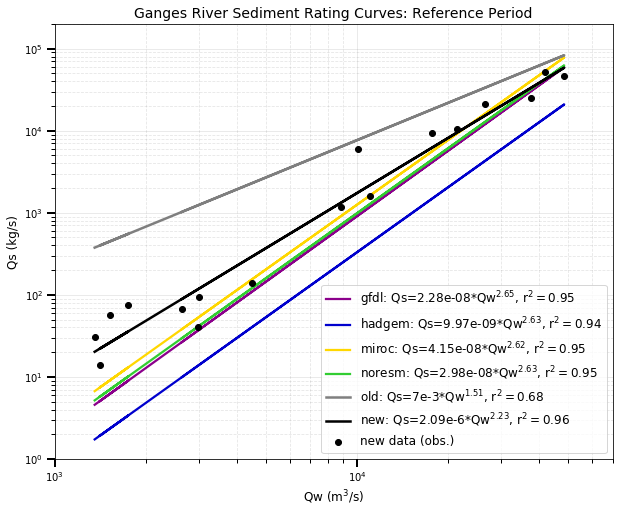

In [7]:
y_new = 2.09e-6*x**2.23         # new curve, obs data
y_old = 7e-3*x**1.51            # old curve
y_gfdl = 2.28e-08*x**2.65       # gfdl curve
y_hadgem = 9.97e-09*x**2.63     # hadgem curve
y_ipsl = 3.55e-09*x**2.62       # ipsl curve
y_miroc = 4.15e-08*x**2.62      # miroc curve
y_noresm = 2.98e-08*x**2.63     # noresm curve

fig, ax = plt.subplots(figsize = (10,8))
ax.grid(b=True, which='major', color='grey', linestyle='-', alpha = 0.2)
ax.grid(b=True, which='minor', color='grey', linestyle='--', alpha = 0.2)

plt.plot(x, y_gfdl, label = 'gfdl: Qs=2.28e-08*Qw$^{2.65}$, $r^2=0.95$', color='darkmagenta', linestyle = 'solid', linewidth = 2.25, zorder=2)
plt.plot(x, y_hadgem, label = 'hadgem: Qs=9.97e-09*Qw$^{2.63}$, $r^2=0.94$', color = 'mediumblue', linestyle = 'solid', linewidth = 2.25, zorder=2)
#plt.plot(x, y_ipsl, label = 'ipsl: Qs=3.55e-09*Qw$^{2.62}$, $r^2=0.93$', color = 'mediumturquoise', linestyle = 'solid', linewidth = 2.25, zorder=2)
plt.plot(x, y_miroc, label = 'miroc: Qs=4.15e-08*Qw$^{2.62}$, $r^2=0.95$', color = 'gold', linestyle = 'solid', linewidth = 2.25, zorder=2)
plt.plot(x, y_noresm, label = 'noresm: Qs=2.98e-08*Qw$^{2.63}$, $r^2=0.95$', color = 'limegreen', linestyle = 'solid', linewidth = 2.25, zorder=2)
plt.plot(x, y_old, label = 'old: Qs=7e-3*Qw$^{1.51}$, $r^2=0.68$', color = "tab:gray", linestyle = 'solid', linewidth = 2.5)
plt.plot(x, y_new, label = 'new: Qs=2.09e-6*Qw$^{2.23}$, $r^2=0.96$', color = "k", linestyle = "solid", linewidth = 2.5)
plt.scatter(x, y, label='new data (obs.)', color = "k", zorder=3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(10e2, 7e4)
ax.set_ylim(1e0, 2e5)
ax.set_ylabel('Qs (kg/s)', size = 12)
ax.set_xlabel('Qw (m$^3/$s)', size = 12)
ax.tick_params(which = 'major', width = 2, length = 8)
ax.tick_params(which = 'minor', width = 1, length = 4)
plt.title('Ganges River Sediment Rating Curves: Reference Period', size = 14)
plt.legend(loc = 4, prop={'size': 12})
plt.show()

fig.savefig('../../figures/v2/sed_cal/rating_curve_GR.png', size = 300)

### 2.2. Recent (2020) time period

#### 2.2a) Load HT data (rcp4.5 and rcp8.5 scenarios)

In [8]:
# Rcp4.5
# Qw
gfdl_qw_4p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp4p5/GFDL-ESM2M/2020/Hydrotrend/HYDROASCII.Q', skip_header = True)
hadgem_qw_4p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp4p5/HadGEM2/2020/Hydrotrend/HYDROASCII.Q', skip_header = True)
ipsl_qw_4p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp4p5/IPSL_CM5A/2020/Hydrotrend/HYDROASCII.Q', skip_header = True)
miroc_qw_4p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp4p5/MIROC-ESM-CHEM/2020/Hydrotrend/HYDROASCII.Q', skip_header = True)
noresm_qw_4p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp4p5/NORESM-M/2020/Hydrotrend/HYDROASCII.Q', skip_header = True)
# Qs
gfdl_qs_4p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp4p5/GFDL-ESM2M/2020/Hydrotrend/HYDROASCII.QS', skip_header = True)
hadgem_qs_4p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp4p5/HadGEM2/2020/Hydrotrend/HYDROASCII.QS', skip_header = True)
ipsl_qs_4p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp4p5/IPSL_CM5A/2020/Hydrotrend/HYDROASCII.QS', skip_header = True)
miroc_qs_4p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp4p5/MIROC-ESM-CHEM/2020/Hydrotrend/HYDROASCII.QS', skip_header = True)
noresm_qs_4p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp4p5/NORESM-M/2020/Hydrotrend/HYDROASCII.QS', skip_header = True)

In [9]:
# Rcp8.5
# Qw
gfdl_qw_8p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp8p5/GFDL-ESM2M/2020/Hydrotrend/HYDROASCII.Q', skip_header = True)
hadgem_qw_8p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp8p5/HadGEM2/2020/Hydrotrend/HYDROASCII.Q', skip_header = True)
ipsl_qw_8p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp8p5/IPSL_CM5A/2020/Hydrotrend/HYDROASCII.Q', skip_header = True)
miroc_qw_8p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp8p5/MIROC-ESM-CHEM/2020/Hydrotrend/HYDROASCII.Q', skip_header = True)
noresm_qw_8p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp8p5/NORESM-M/2020/Hydrotrend/HYDROASCII.Q', skip_header = True)
# Qs
gfdl_qs_8p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp8p5/GFDL-ESM2M/2020/Hydrotrend/HYDROASCII.QS', skip_header = True)
hadgem_qs_8p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp8p5/HadGEM2/2020/Hydrotrend/HYDROASCII.QS', skip_header = True)
ipsl_qs_8p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp8p5/IPSL_CM5A/2020/Hydrotrend/HYDROASCII.QS', skip_header = True)
miroc_qs_8p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp8p5/MIROC-ESM-CHEM/2020/Hydrotrend/HYDROASCII.QS', skip_header = True)
noresm_qs_8p5 = np.genfromtxt('../../setup/run_2/Ganga/rcp8p5/NORESM-M/2020/Hydrotrend/HYDROASCII.QS', skip_header = True)

#### 2.2b) Clip arrays to be only 2 years worth of data (2019-2020)

In [10]:
# Rcp4.5
# Qw
gfdl_qw_4p5_clip = np.array(gfdl_qw_4p5[4745:5475])
hadgem_qw_4p5_clip = np.array(hadgem_qw_4p5[4745:5475])
ipsl_qw_4p5_clip = np.array(ipsl_qw_4p5[4745:5475])
miroc_qw_4p5_clip = np.array(miroc_qw_4p5[4745:5475])
noresm_qw_4p5_clip = np.array(noresm_qw_4p5[4745:5475])
# Qs
gfdl_qs_4p5_clip = np.array(gfdl_qs_4p5[4745:5475])
hadgem_qs_4p5_clip = np.array(hadgem_qs_4p5[4745:5475])
ipsl_qs_4p5_clip = np.array(ipsl_qs_4p5[4745:5475])
miroc_qs_4p5_clip = np.array(miroc_qs_4p5[4745:5475])
noresm_qs_4p5_clip = np.array(noresm_qs_4p5[4745:5475])

In [11]:
# Rcp8.5
# Qw
gfdl_qw_8p5_clip = np.array(gfdl_qw_8p5[4745:5475])
hadgem_qw_8p5_clip = np.array(hadgem_qw_8p5[4745:5475])
ipsl_qw_8p5_clip = np.array(ipsl_qw_8p5[4745:5475])
miroc_qw_8p5_clip = np.array(miroc_qw_8p5[4745:5475])
noresm_qw_8p5_clip = np.array(noresm_qw_8p5[4745:5475])
# Qs
gfdl_qs_8p5_clip = np.array(gfdl_qs_8p5[4745:5475])
hadgem_qs_8p5_clip = np.array(hadgem_qs_8p5[4745:5475])
ipsl_qs_8p5_clip = np.array(ipsl_qs_8p5[4745:5475])
miroc_qs_8p5_clip = np.array(miroc_qs_8p5[4745:5475])
noresm_qs_8p5_clip = np.array(noresm_qs_8p5[4745:5475])

#### 2.2c) Generate new rating curves from 2 years of HT data (2019-2020) ***for Rcp4.5***

In [12]:
# Rcp4.5
print('New rating curve slope and intercept for 2 years, Rcp4.5')
gfdl_4p5 = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(gfdl_qw_4p5_clip[1:]), np.log(gfdl_qs_4p5_clip[1:]))
print('gfdl: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(gfdl_4p5.slope, np.exp(gfdl_4p5.intercept), gfdl_4p5.rvalue**2))

hadgem_4p5 = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(hadgem_qw_4p5_clip[1:]), np.log(hadgem_qs_4p5_clip[1:]))
print('hadgem: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(hadgem_4p5.slope, np.exp(hadgem_4p5.intercept), hadgem_4p5.rvalue**2))

ipsl_4p5 = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(ipsl_qw_4p5_clip[1:]), np.log(ipsl_qs_4p5_clip[1:]))
print('ipsl: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(ipsl_4p5.slope, np.exp(ipsl_4p5.intercept), ipsl_4p5.rvalue**2))

miroc_4p5 = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(miroc_qw_4p5_clip[1:]), np.log(miroc_qs_4p5_clip[1:]))
print('miroc: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(miroc_4p5.slope, np.exp(miroc_4p5.intercept), miroc_4p5.rvalue**2))

noresm_4p5 = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(noresm_qw_4p5_clip[1:]), np.log(noresm_qs_4p5_clip[1:]))
print('noresm: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(noresm_4p5.slope, np.exp(noresm_4p5.intercept), noresm_4p5.rvalue**2))

New rating curve slope and intercept for 2 years, Rcp4.5
gfdl: slope:2.5    intercept: 9.89e-08    r-squared: 0.96
hadgem: slope:2.46    intercept: 2.98e-08    r-squared: 0.96
ipsl: slope:2.53    intercept: 1.09e-08    r-squared: 0.97
miroc: slope:2.5    intercept: 1.39e-07    r-squared: 0.97
noresm: slope:2.51    intercept: 5.82e-08    r-squared: 0.97


#### 2.2d) Plot new rating curves from 2 years of HT data (2019-2020) ***for Rcp4.5***

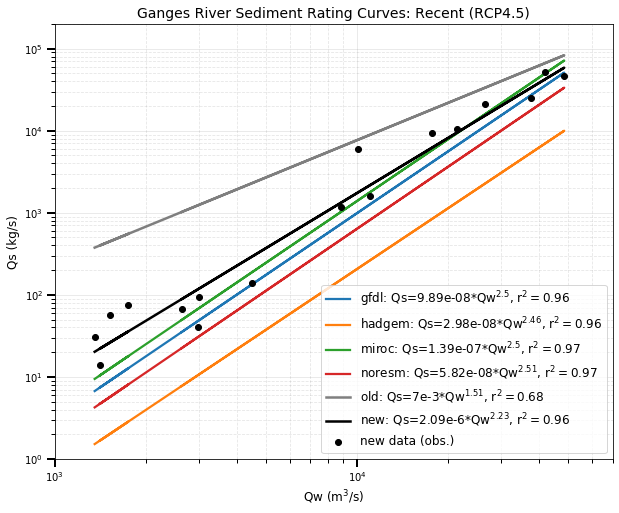

In [13]:
# Rcp4.5

y_new = 2.09e-06*x**2.23         # new curve, obs data
y_old = 7e-3*x**1.51             # old curve
y_gfdl = 9.89e-08*x**2.5         # gfdl curve
y_hadgem = 2.98e-08*x**2.46      # hadgem curve
y_ipsl = 1.09e-08*x**2.53        # ipsl curve
y_miroc = 1.39e-07*x**2.5        # miroc curve
y_noresm = 5.82e-08*x**2.51      # noresm curve

fig, ax = plt.subplots(figsize = (10,8))
ax.grid(b=True, which='major', color='grey', linestyle='-', alpha = 0.2)
ax.grid(b=True, which='minor', color='grey', linestyle='--', alpha = 0.2)

plt.plot(x, y_gfdl, label = 'gfdl: Qs=9.89e-08*Qw$^{2.5}$, $r^2=0.96$', linestyle = 'solid', linewidth = 2.25, zorder=2)
plt.plot(x, y_hadgem, label = 'hadgem: Qs=2.98e-08*Qw$^{2.46}$, $r^2=0.96$', linestyle = 'solid', linewidth = 2.25, zorder=2)
#plt.plot(x, y_ipsl, label = 'ipsl: Qs=1.09e-08*Qw$^{2.53}$, $r^2=0.97$',  linestyle = 'solid', linewidth = 2.25, zorder=2)
plt.plot(x, y_miroc, label = 'miroc: Qs=1.39e-07*Qw$^{2.5}$, $r^2=0.97$', linestyle = 'solid', linewidth = 2.25, zorder=2)
plt.plot(x, y_noresm, label = 'noresm: Qs=5.82e-08*Qw$^{2.51}$, $r^2=0.97$',  linestyle = 'solid', linewidth = 2.25, zorder=2)
plt.plot(x, y_old, label = 'old: Qs=7e-3*Qw$^{1.51}$, $r^2=0.68$', color = "tab:gray", linestyle = 'solid', linewidth = 2.5)
plt.plot(x, y_new, label = 'new: Qs=2.09e-6*Qw$^{2.23}$, $r^2=0.96$', color = "k", linestyle = "solid", linewidth = 2.5)
plt.scatter(x, y, label='new data (obs.)', color = "k", zorder=3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(10e2, 7e4)
ax.set_ylim(1e0, 2e5)
ax.set_ylabel('Qs (kg/s)', size = 12)
ax.set_xlabel('Qw (m$^3/$s)', size = 12)
ax.tick_params(which = 'major', width = 2, length = 8)
ax.tick_params(which = 'minor', width = 1, length = 4)
plt.title('Ganges River Sediment Rating Curves: Recent (RCP4.5)', size = 14)
plt.legend(loc = 4, prop={'size': 12})
plt.show()

fig.savefig('../../figures/v2/sed_cal/rating_curve_GR_4p5.png', size = 300)

#### 2.2e) Generate new rating curves from 2 years of HT data (2019-2020) ***for Rcp8.5***

In [14]:
# Rcp8.5

print('New rating curve slope and intercept for 2 years, Rcp8.5')
gfdl_8p5 = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(gfdl_qw_8p5_clip[1:]), np.log(gfdl_qs_8p5_clip[1:]))
print('gfdl: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(gfdl_8p5.slope, np.exp(gfdl_8p5.intercept), gfdl_8p5.rvalue**2))

hadgem_8p5 = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(hadgem_qw_8p5_clip[1:]), np.log(hadgem_qs_8p5_clip[1:]))
print('hadgem: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(hadgem_8p5.slope, np.exp(hadgem_8p5.intercept), hadgem_8p5.rvalue**2))

ipsl_8p5 = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(ipsl_qw_8p5_clip[1:]), np.log(ipsl_qs_8p5_clip[1:]))
print('ipsl: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(ipsl_8p5.slope, np.exp(ipsl_8p5.intercept), ipsl_8p5.rvalue**2))

miroc_8p5 = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(miroc_qw_8p5_clip[1:]), np.log(miroc_qs_8p5_clip[1:]))
print('miroc: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(miroc_8p5.slope, np.exp(miroc_8p5.intercept), miroc_8p5.rvalue**2))

noresm_8p5 = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(noresm_qw_8p5_clip[1:]), np.log(noresm_qs_8p5_clip[1:]))
print('noresm: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(noresm_8p5.slope, np.exp(noresm_8p5.intercept), noresm_8p5.rvalue**2))

New rating curve slope and intercept for 2 years, Rcp8.5
gfdl: slope:2.47    intercept: 1.26e-07    r-squared: 0.97
hadgem: slope:2.54    intercept: 1.49e-08    r-squared: 0.96
ipsl: slope:2.51    intercept: 3.41e-08    r-squared: 0.95
miroc: slope:2.48    intercept: 1.33e-07    r-squared: 0.97
noresm: slope:2.46    intercept: 9.26e-08    r-squared: 0.97


#### 2.2f) Plot new rating curves from 2 years of HT data (2019-2020) ***for Rcp8.5***

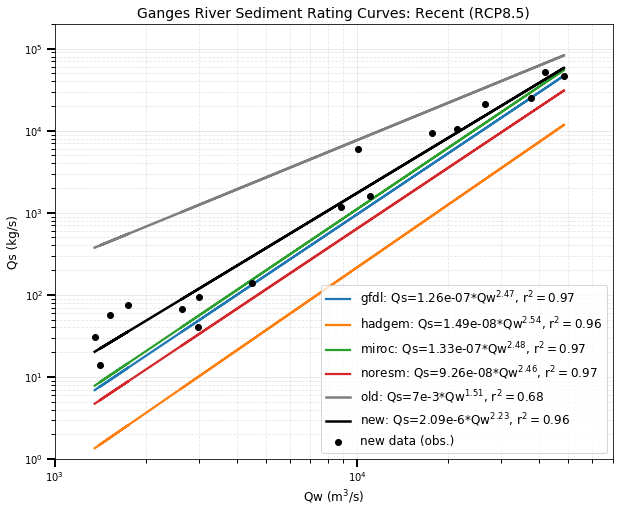

In [15]:
# Rcp8.5

y_new = 2.09e-6*x**2.23         # new curve, obs data
y_old = 7e-3*x**1.51            # old curve
y_gfdl = 1.26e-07*x**2.47       # gfdl curve
y_hadgem = 1.49e-08*x**2.54     # hadgem curve
y_ipsl = 3.41e-08*x**2.51       # ipsl curve
y_miroc = 1.33e-07*x**2.48      # miroc curve
y_noresm = 9.26e-08*x**2.46     # noresm curve

fig, ax = plt.subplots(figsize = (10,8))
ax.grid(b=True, which='major', color='grey', linestyle='-', alpha = 0.2)
ax.grid(b=True, which='minor', color='grey', linestyle='--', alpha = 0.2)

plt.plot(x, y_gfdl, label = 'gfdl: Qs=1.26e-07*Qw$^{2.47}$, $r^2=0.97$', linestyle = 'solid', linewidth = 2.25, zorder=2)
plt.plot(x, y_hadgem, label = 'hadgem: Qs=1.49e-08*Qw$^{2.54}$, $r^2=0.96$', linestyle = 'solid', linewidth = 2.25, zorder=2)
#plt.plot(x, y_ipsl, label = 'ipsl: Qs=3.41e-08*Qw$^{2.51}$, $r^2=0.95$', linestyle = 'solid', linewidth = 2.25, zorder=2)
plt.plot(x, y_miroc, label = 'miroc: Qs=1.33e-07*Qw$^{2.48}$, $r^2=0.97$', linestyle = 'solid', linewidth = 2.25, zorder=2)
plt.plot(x, y_noresm, label = 'noresm: Qs=9.26e-08*Qw$^{2.46}$, $r^2=0.97$', linestyle = 'solid', linewidth = 2.25, zorder=2)
plt.plot(x, y_old, label = 'old: Qs=7e-3*Qw$^{1.51}$, $r^2=0.68$', color = "tab:gray", linestyle = 'solid', linewidth = 2.5)
plt.plot(x, y_new, label = 'new: Qs=2.09e-6*Qw$^{2.23}$, $r^2=0.96$', color = "k", linestyle = "solid", linewidth = 2.5)
plt.scatter(x, y, label='new data (obs.)', color = "k", zorder=3)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(10e2, 7e4)
ax.set_ylim(1e0, 2e5)
ax.set_ylabel('Qs (kg/s)', size = 12)
ax.set_xlabel('Qw (m$^3/$s)', size = 12)
ax.tick_params(which = 'major', width = 2, length = 8)
ax.tick_params(which = 'minor', width = 1, length = 4)
plt.title('Ganges River Sediment Rating Curves: Recent (RCP8.5)', size = 14)
plt.legend(loc = 4, prop={'size': 12})
plt.show()

fig.savefig('../../figures/v2/sed_cal/rating_curve_GR_8p5.png', size = 300)

## Part 3: Compute sediment loads using various methods; compare simulated with observed

### 3.1. Observed Qs values

#### 3.1a)  Compute HISTORIC sediment load via historic rating curve

In [16]:
# Re-import observed water discharge data as pandas dataframe
data_obs_qw = pd.DataFrame(pd.read_csv('../../water_data/Ganges/Hardinge_Qw_1976-2006.csv'))
data_obs_qw['Date'] = pd.to_datetime(data_obs_qw['Date'], format="%m/%d/%y")
data_obs_qw

Date  Discharge (m3/s)
0     1976-01-01            2410.0
1     1976-01-02            2370.0
2     1976-01-03            2320.0
3     1976-01-04            2270.0
4     1976-01-05            2180.0
...          ...               ...
10945 2005-12-20            2664.0
10946 2005-12-21            2596.0
10947 2005-12-22            2529.0
10948 2005-12-23            2463.0
10949 2005-12-24            2437.0

[10950 rows x 2 columns]

In [17]:
# Plug in historic observed data into historic rating curve
# Get average sediment load over reference scenario
data_obs_qs = 7e-3*(data_obs_qw['Discharge (m3/s)']**1.51)
data_obs_qs_sum = data_obs_qs.sum()
data_obs_qs_avg_kgs = data_obs_qs_sum/10950
data_obs_qs_avg_mtyr = data_obs_qs_avg_kgs*3.14e7/1e9
print('Avg Qs over HISTORIC observation time period (MT/yr): {:.5}'.format(data_obs_qs_avg_mtyr))

Avg Qs over HISTORIC observation time period (MT/yr): 451.89


#### 3.1b) Compute RECENT sediment load from new observed water data via new rating curve (from 2.3)

In [18]:
# Average sediment load over 16 discrete samples
obs_avg_2020_new = 2.09e-06*(data_obs_new['Discharge (m3/S)']**2.23)
obs_qs_annual_btyr_new = ((obs_avg_2020_new.sum()*3.154e7/1e9))/16
print('New (obs): Qs in BT/yr: {:.4}'.format(obs_qs_annual_btyr_new))

New (obs): Qs in BT/yr: 337.2


### 3.2. Simulated Qs values

#### 3.2a) Compute HISTORIC Qs using HT-generated rating curves

In [19]:
# Import hydrotrend data (over reference scenario)
# Qw
gfdl_qw = np.genfromtxt('../../setup/run_2/Ganga/reference/GFDL-ESM2M/Hydrotrend/HYDROASCII.Q', skip_header = True)
hadgem_qw = np.genfromtxt('../../setup/run_2/Ganga/reference/HadGEM2/Hydrotrend/HYDROASCII.Q', skip_header = True)
ipsl_qw = np.genfromtxt('../../setup/run_2/Ganga/reference/IPSL_CM5A/Hydrotrend/HYDROASCII.Q', skip_header = True)
miroc_qw = np.genfromtxt('../../setup/run_2/Ganga/reference/MIROC-ESM-CHEM/Hydrotrend/HYDROASCII.Q', skip_header = True)
noresm_qw = np.genfromtxt('../../setup/run_2/Ganga/reference/NORESM-M/Hydrotrend/HYDROASCII.Q', skip_header = True)
# Qs
gfdl_qs = np.genfromtxt('../../setup/run_2/Ganga/reference/GFDL-ESM2M/Hydrotrend/HYDROASCII.QS', skip_header = True)
hadgem_qs = np.genfromtxt('../../setup/run_2/Ganga/reference/HadGEM2/Hydrotrend/HYDROASCII.QS', skip_header = True)
ipsl_qs = np.genfromtxt('../../setup/run_2/Ganga/reference/IPSL_CM5A/Hydrotrend/HYDROASCII.QS', skip_header = True)
miroc_qs = np.genfromtxt('../../setup/run_2/Ganga/reference/MIROC-ESM-CHEM/Hydrotrend/HYDROASCII.QS', skip_header = True)
noresm_qs = np.genfromtxt('../../setup/run_2/Ganga/reference/NORESM-M/Hydrotrend/HYDROASCII.QS', skip_header = True)

In [20]:
# Calculate new rating curve stats from HT outputs
gfdl = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(gfdl_qw[1:]), np.log(gfdl_qs[1:]))
print('gfdl: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(gfdl.slope, np.exp(gfdl.intercept), gfdl.rvalue**2))

hadgem = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(hadgem_qw[1:]), np.log(hadgem_qs[1:]))
print('hadgem: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(hadgem.slope, np.exp(hadgem.intercept), hadgem.rvalue**2))

ipsl = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(ipsl_qw[1:]), np.log(ipsl_qs[1:]))
print('ipsl: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(ipsl.slope, np.exp(ipsl.intercept), ipsl.rvalue**2))

miroc = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(miroc_qw[1:]), np.log(miroc_qs[1:]))
print('miroc: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(miroc.slope, np.exp(miroc.intercept), miroc.rvalue**2))

noresm = slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(noresm_qw[1:]), np.log(noresm_qs[1:]))
print('noresm: slope:{:.3}    intercept: {:.3}    r-squared: {:.2}'.format(noresm.slope, np.exp(noresm.intercept), noresm.rvalue**2))

gfdl: slope:2.65    intercept: 2.28e-08    r-squared: 0.95
hadgem: slope:2.63    intercept: 9.97e-09    r-squared: 0.94
ipsl: slope:2.62    intercept: 3.55e-09    r-squared: 0.93
miroc: slope:2.62    intercept: 4.15e-08    r-squared: 0.95
noresm: slope:2.63    intercept: 2.98e-08    r-squared: 0.95


In [21]:
# Plug in water data to rating curve equation
qs_gfdl = 2.28e-08*(gfdl_qw**2.65)   
qs_hadgem = 9.97e-09*(hadgem_qw**2.63) 
qs_ipsl = 3.55e-09*(ipsl_qw**2.62)       
qs_miroc = 4.15e-08*(miroc_qw**2.62)       
qs_noresm = 2.98e-08*(noresm_qw**2.63)      

In [22]:
# Convert from kg/s to mt/yr
qs_gfdl_mtyr = (qs_gfdl[1:].sum()/9856)*3.14e7/1e9
qs_hadgem_mtyr = (qs_hadgem[1:].sum()/9856)*3.14e7/1e9
qs_miroc_mtyr = (qs_miroc[1:].sum()/9856)*3.14e7/1e9
qs_noresm_mtyr = (qs_noresm[1:].sum()/9856)*3.14e7/1e9

In [23]:
# Print results
print('Qs computed from HT data and HT rating curves over reference scenario (MT/yr):')
print('GFDL: {:.5}'.format(qs_gfdl_mtyr))
print('HadGEM: {:.5}'.format(qs_hadgem_mtyr))
print('MIROC: {:.5}'.format(qs_miroc_mtyr))
print('NORESM: {:.5}'.format(qs_noresm_mtyr))
print('Average: {:.5}'.format((qs_gfdl_mtyr + qs_hadgem_mtyr + qs_miroc_mtyr + qs_noresm_mtyr)/4))

Qs computed from HT data and HT rating curves over reference scenario (MT/yr):
GFDL: 589.97
HadGEM: 479.52
MIROC: 559.18
NORESM: 552.63
Average: 545.32


#### 3.2b) Compute RECENT Qs from HT data over observation time period (2019-2020)

#### - Use new rating curve (from 2.4c) ***for Rcp4.5***

In [24]:
# Rcp4.5
gfdl_qs_2020_ht = 9.89e-08*(gfdl_qw_4p5[4745:5475]**2.5)
hadgem_qs_2020_ht = 2.98e-08*(hadgem_qw_4p5[4745:5475]**2.46)
ipsl_qs_2020_ht = 1.09e-08*(ipsl_qw_4p5[4745:5475]**2.53)
miroc_qs_2020_ht = 1.39e-07*(miroc_qw_4p5[4745:5475]**2.5)
noresm_qs_2020_ht = 5.82e-08*(noresm_qw_4p5[4745:5475]**2.51)

In [25]:
# Function to calculate Qs in MT/yr for rating curves:
def annual_load_BT(qs):
    return ((((qs.sum())*3.154e7/1e9))/2/365)

gfdl_qs_annual_btyr_ht = annual_load_BT(gfdl_qs_2020_ht)
hadgem_qs_annual_btyr_ht = annual_load_BT(hadgem_qs_2020_ht)
ipsl_qs_annual_btyr_ht = annual_load_BT(ipsl_qs_2020_ht)
miroc_qs_annual_btyr_ht = annual_load_BT(miroc_qs_2020_ht)
noresm_qs_annual_btyr_ht = annual_load_BT(noresm_qs_2020_ht)

In [26]:
# print Qs for all climate models
print('Qs computed using HT-generated rating curve, Rcp4.5 data, 2019-2020:')
print('GFDL: Qs in MT/yr: {:.4}'.format(gfdl_qs_annual_btyr_ht))
print('HadGEM: Qs in MT/yr: {:.4}'.format(hadgem_qs_annual_btyr_ht))
#print('IPSL: Qs in BT/yr: {:.4}'.format(ipsl_qs_annual_btyr_ht))
print('MIROC: Qs in MT/yr: {:.4}'.format(miroc_qs_annual_btyr_ht))
print('NORESM: Qs in MT/yr: {:.4}'.format(noresm_qs_annual_btyr_ht))
average_ht = (gfdl_qs_annual_btyr_ht + hadgem_qs_annual_btyr_ht + miroc_qs_annual_btyr_ht + noresm_qs_annual_btyr_ht)/4
print('Average: Qs in MT/yr: {:.4}'.format(average_ht))

Qs computed using HT-generated rating curve, Rcp4.5 data, 2019-2020:
GFDL: Qs in MT/yr: 151.6
HadGEM: Qs in MT/yr: 361.4
MIROC: Qs in MT/yr: 377.8
NORESM: Qs in MT/yr: 622.2
Average: Qs in MT/yr: 378.3


#### - Use new rating curve (from 2.4e) ***for Rcp8.5***

In [27]:
# Rcp8.5
gfdl_qs_2020_ht = 1.26e-07*(gfdl_qw_8p5[4745:5475]**2.47)
hadgem_qs_2020_ht = 1.49e-08*(hadgem_qw_8p5[4745:5475]**2.54)
ipsl_qs_2020_ht = 3.41e-08*(ipsl_qw_8p5[4745:5475]**2.51)
miroc_qs_2020_ht = 1.33e-07*(miroc_qw_8p5[4745:5475]**2.48)
noresm_qs_2020_ht = 9.26e-08*(noresm_qw_8p5[4745:5475]**2.46)

In [28]:
# Function to calculate Qs in MT/yr for rating curves:
def annual_load_BT(qs):
    return ((((qs.sum())*3.154e7/1e9))/2/365)

gfdl_qs_annual_btyr_ht = annual_load_BT(gfdl_qs_2020_ht)
hadgem_qs_annual_btyr_ht = annual_load_BT(hadgem_qs_2020_ht)
ipsl_qs_annual_btyr_ht = annual_load_BT(ipsl_qs_2020_ht)
miroc_qs_annual_btyr_ht = annual_load_BT(miroc_qs_2020_ht)
noresm_qs_annual_btyr_ht = annual_load_BT(noresm_qs_2020_ht)

In [29]:
# Print Qs for all climate models
print('Qs computed using HT-generated rating curve, Rcp8.5 data, 2019-2020:')
print('GFDL: Qs in MT/yr: {:.4}'.format(gfdl_qs_annual_btyr_ht))
print('HadGEM: Qs in MT/yr: {:.4}'.format(hadgem_qs_annual_btyr_ht))
#print('IPSL: Qs in BT/yr: {:.4}'.format(ipsl_qs_annual_btyr_ht))
print('MIROC: Qs in MT/yr: {:.4}'.format(miroc_qs_annual_btyr_ht))
print('NORESM: Qs in MT/yr: {:.4}'.format(noresm_qs_annual_btyr_ht))
average_ht = (gfdl_qs_annual_btyr_ht + hadgem_qs_annual_btyr_ht + miroc_qs_annual_btyr_ht + noresm_qs_annual_btyr_ht)/4
print('Average: Qs in MT/yr: {:.4}'.format(average_ht))

Qs computed using HT-generated rating curve, Rcp8.5 data, 2019-2020:
GFDL: Qs in MT/yr: 389.6
HadGEM: Qs in MT/yr: 869.4
MIROC: Qs in MT/yr: 306.9
NORESM: Qs in MT/yr: 389.0
Average: Qs in MT/yr: 488.7
